In [1]:
%matplotlib inline

In [2]:
import sys
import numpy as np
import pickle
import skimage.io as io
from sklearn.metrics import precision_recall_fscore_support
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/home/ubuntu/liuxq/experiment/common/my_utils/')
from fusion import get_rowcol

In [4]:
DATA_FILE = '/home/ubuntu/liuxq/experiment/data/VaihingenRaster/top/top_mosaic_09cm_area{}.tif'

In [5]:
LABEL_FILE = '/home/ubuntu/liuxq/experiment/data/VaihingenRaster/gts_for_participants/top_mosaic_09cm_area{}.tif'

In [6]:
IMAGE_LABELS = ['imp sur','building', 'low veg', 'tree', 'others']

In [7]:
'''
palette = {0 : (169, 170, 126), # Impervious surfaces (white)
           1 : (255, 170, 130),     # Buildings (blue)
           2 : (170, 255, 126),   # Low vegetation (cyan)
           3 : (0, 170, 0),     # Trees (green)
           4 : (255, 255, 127),
           5 : (170, 0, 0),
           6 : (0, 0, 0)}       # others include Cars, Clutter and Undefined
'''

palette = {0 : (170, 255, 126),   # Low vegetation
           1 : (0, 170, 0),       # Tree
           2 : (169, 170, 126),   # Impervious surface
           3 : (255, 255, 0),     # Car
           4 : (255, 170, 130),   # Building (blue)
           5 : (170, 0, 0)}       # background        

def convert_to_color(arr_2d, palette=palette):
    """Numeric labels to RGB-color encoding"""
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1],3), dtype=np.uint8)
    
    for c, i in palette.items():
        m = arr_2d==c
        arr_3d[m] = i
        
    return arr_3d

invert_palette = {(255, 255, 255) : 2, # Impervious surfaces (white)
                  (0, 0, 255) : 4,     # Buildings (blue)
                  (0, 255, 255) : 0,   # Low vegetation (cyan)
                  (0, 255, 0) : 1,     # Trees (green)
                  (255, 255, 0) : 3,   # Cars (yellow)
                  (255, 0, 0) : 5,     # Clutter (red)
                  (0, 0, 0) : 5}       # Undefined (black)

def convert_from_color(arr_3d, palette=invert_palette):
    """RGB-color encoding to grayscale labels"""
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)
    
    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1,1,3), axis=2)
        arr_2d[m] = i
    
    return arr_2d

## Fusuion

### Validate raster result

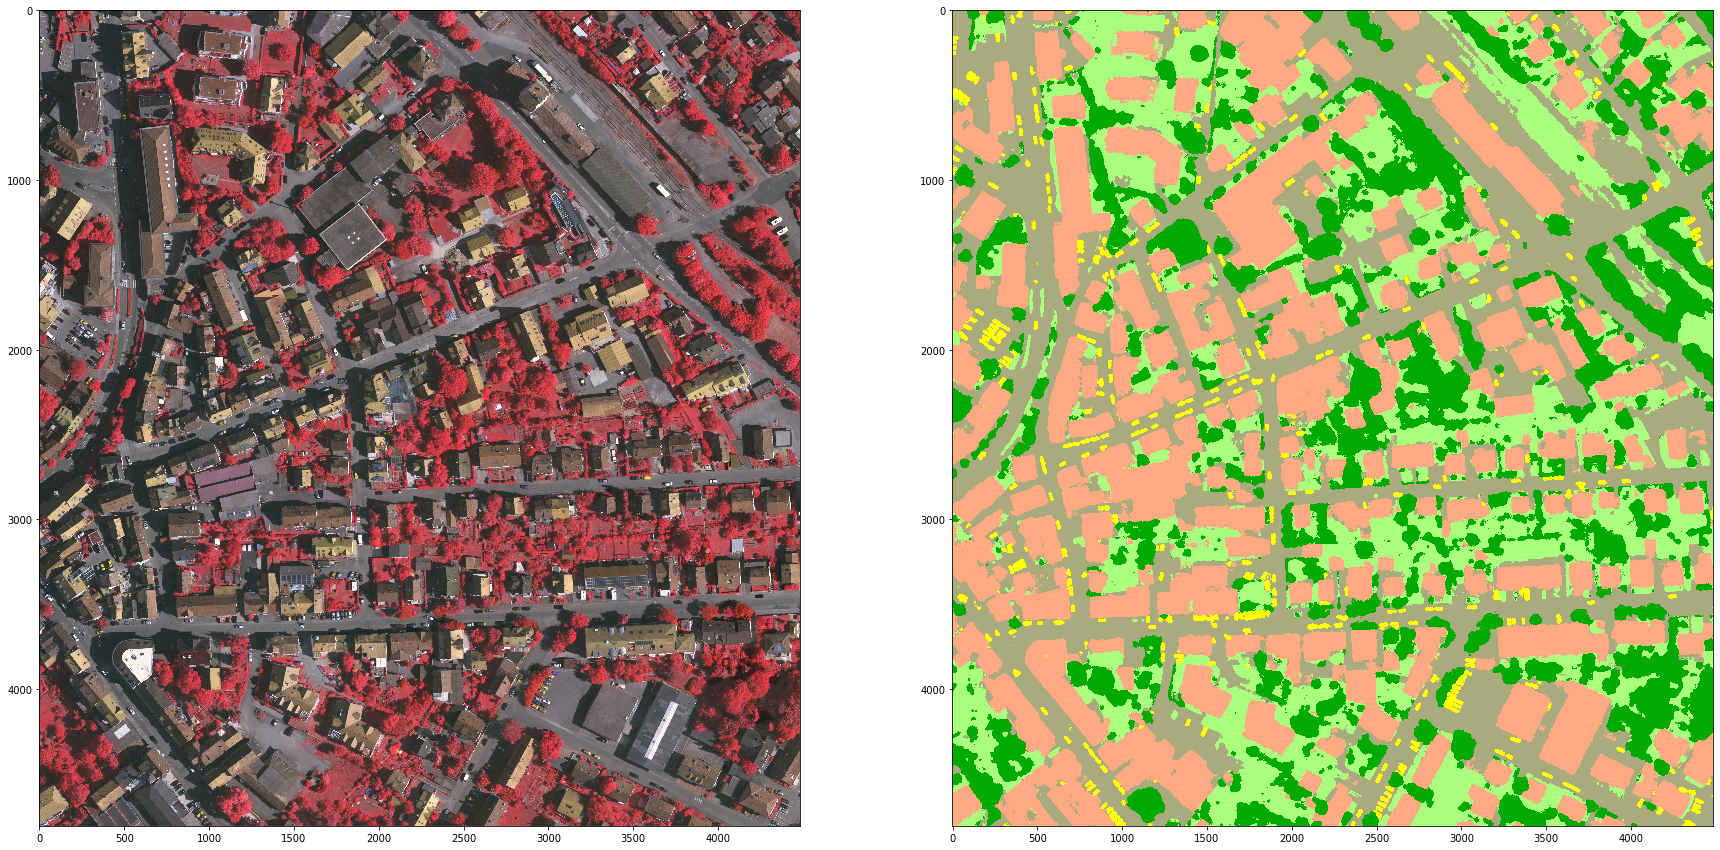

In [9]:
prob_raster_test = np.load('/media/ubuntu/Xu_02/liuxq/experiment/4_decision_level/data/prob_raster_test.npy')
pred_raster_test = np.argmax(prob_raster_test, axis=-1)
pred_raster_test = convert_to_color(pred_raster_test)
raster_test = io.imread('../../data/fill_test.tif')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[30,60])
axes[0].imshow(raster_test)
axes[1].imshow(pred_raster_test)

In [10]:
point_train = np.loadtxt('../../data/Vaihingen3D_training.txt')
point_xyz_train = point_train[:, :3] - np.min(point_train[:, :3], axis=0)
point_gts_train = point_train[:, -1]
point_test = np.loadtxt('../../data/Vaihingen3D_EVAL_WITH_REF.txt')
point_xyz_test = point_test[:, :3] - np.min(point_test[:, :3], axis=0)
point_gts_test = point_test[:, -1]

In [11]:
geotransform = {'train': [-15.04, 0.09, 0.0, 420.36, 0.0, -0.09],
                'test':  [-15.03, 0.09, 0.0, 417.64, 0.0, -0.09]}

In [12]:
raster_to_point = np.zeros((point_xyz_test.shape[0], prob_raster_test.shape[-1]))
for i in range(len(point_xyz_test)):
    col, row = get_rowcol(point_xyz_test[i][0:2], geotransform['test'])
    raster_to_point[i] = prob_raster_test[row][col]
prob_raster_test = raster_to_point

In [13]:
pred_raster_test = np.argmax(prob_raster_test, axis=-1)
relation = {0:5, 1:0, 2:2, 3:3, 4:5, 5:4, 6:4, 7:0, 8:1}
gts = np.asarray(point_gts_test.copy(), dtype='int')
for i in range(len(gts)):
    gts[i] = relation[gts[i]]

In [14]:
precision_recall_fscore_support(gts, pred_raster_test, average='weighted')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.7840332051475336, 0.772122937321785, 0.7640253227650985, None)

In [15]:
precision_recall_fscore_support(gts, pred_raster_test)

(array([0.83805445, 0.57318665, 0.77761765, 0.18720509, 0.89975556,
        0.        ]),
 array([0.55453898, 0.86665068, 0.88884749, 0.4600863 , 0.91508414,
        0.        ]),
 array([0.66743652, 0.69001211, 0.8295205 , 0.26612589, 0.90735512,
        0.        ]),
 array([123508,  54226, 101986,   3708, 120272,   8022]))

### Validate fusion result

In [16]:
prob_point_train = np.load('/media/ubuntu/Xu_02/liuxq/experiment/4_decision_level/data/ds2010/prob_point_train.npy')
prob_point_test = np.load('/media/ubuntu/Xu_02/liuxq/experiment/4_decision_level/data/ds2010/prob_point_test.npy')

In [17]:
prob_fusion_test = np.zeros((prob_point_test.shape[0], 6))
prob_fusion_test[:, 0] = prob_point_test[:, 0] * prob_raster_test[:, 0]
prob_fusion_test[:, 1] = prob_point_test[:, 1] * (prob_raster_test[:, 0] + prob_raster_test[:, 1])/2
prob_fusion_test[:, 2] = prob_point_test[:, 2] * prob_raster_test[:, 1]
prob_fusion_test[:, 3] = (prob_point_test[:, 3]+prob_point_test[:, 4]) * (prob_raster_test[:, 2] + prob_raster_test[:, 3])
prob_fusion_test[:, 4] = prob_point_test[:, 5] * prob_raster_test[:, 4]
prob_fusion_test[:, 5] = prob_point_test[:, 6] * prob_raster_test[:, 4]

In [18]:
pred_fusion_test = np.argmax(prob_fusion_test, axis=-1)

In [19]:
relation = {0:6, 1:0, 2:3, 3:3, 4:6, 5:4, 6:5, 7:1, 8:2}
gts = np.asarray(point_gts_test.copy(), dtype='int')
for i in range(len(gts)):
    gts[i] = relation[gts[i]]

In [20]:
precision_recall_fscore_support(gts, pred_fusion_test, average='weighted')

(0.8369828948077761, 0.8111808453276725, 0.8135106950383022, None)

In [21]:
precision_recall_fscore_support(gts, pred_fusion_test)

(array([0.91910426, 0.34498295, 0.85209786, 0.84228266, 0.96571827,
        0.42733051, 0.        ]),
 array([0.6545952 , 0.6602466 , 0.80671634, 0.95992204, 0.91447803,
        0.71881682, 0.        ]),
 array([0.76462025, 0.45317772, 0.82878633, 0.89726288, 0.93939993,
        0.5360085 , 0.        ]),
 array([ 98690,  24818,  54226, 105694, 109048,  11224,   8022]))

In [22]:
tmp = np.hstack((point_xyz_test, pred_fusion_test.reshape(-1,1)))
np.savetxt('prediction.pts', tmp, fmt='%.2f %.2f %.2f %d')